In [2]:
import numpy
import sympy
from matplotlib import pyplot
import ipywidgets as ipyw
%matplotlib inline





In [3]:
sympy.init_printing()
u_max=sympy.symbols('u_max')
u_star=sympy.symbols('u_star')
rho_max=sympy.symbols('rho_max')
rho_star=sympy.symbols('rho_star')
A,B=sympy.symbols('A B')

In [4]:
u_max

In [7]:
u_max+u_star+A

In [9]:
#no traffic flux at max density
eq1 = sympy.Eq(0, u_max * rho_max * (1 - A * rho_max - B * rho_max**2))
eq1


In [10]:
#max flux when rho = rho_star
eq2 = sympy.Eq(0, u_max * (1 - 2 * A * rho_star - 3 * B * rho_star**2))
eq2

In [11]:
#velocity u_star when rho = rho_star
eq3 = sympy.Eq(u_star, u_max * (1 - A * rho_star - B * rho_star**2))
eq3

In [12]:
eq2 - 3 * eq3

In [13]:
eq4 = sympy.Eq(eq2.lhs - 3 * eq3.lhs, eq2.rhs - 3 * eq3.rhs)
eq4

In [14]:
eq4.simplify()

In [15]:
eq4.expand()

In [21]:
rho_star_sol = sympy.solve(eq4, rho_star)[0]
rho_star_sol

In [22]:
type(rho_star_sol)

sympy.core.mul.Mul

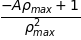

In [23]:
B_sol = sympy.solve(eq1, B)[0]
B_sol

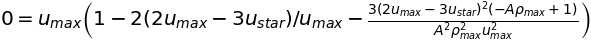

In [24]:
eq5 = eq2.subs([(rho_star, rho_star_sol), (B, B_sol)])
eq5

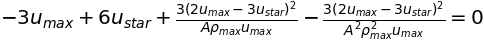

In [26]:
eq5.simplify()

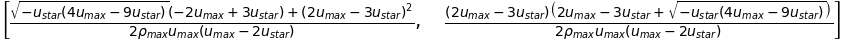

In [29]:
A_sol = sympy.solve(eq5, A)
A_sol

In [33]:
A_val_0 = A_sol[0].evalf(subs={u_star: 0.7, u_max: 1.0, rho_max: 10.0})
A_val_1 = A_sol[1].evalf(subs={u_star: 0.7, u_max: 1.0, rho_max: 10.0})
A_val = max(A_val_0, A_val_1)
A_val

In [34]:
B_val = B_sol.evalf(subs={rho_max: 10.0, A: A_val})
B_val

In [35]:
def cubic_flux(rho,u_max,A,B):
    F = rho * u_max * (1.0 - A * rho - B * rho**2)
    return F

In [61]:
#define parameters
rho_max = 10.0
u_max = 1.0
nx = 81  # number of locations on the road
L = 4.0  # length of the road
dx = L / (nx - 1)  # distance between two consecutive locations
# Define the locations on the road.
x = numpy.linspace(0.0, L, num=nx)


In [86]:
rho0 = numpy.zeros_like(x)
mask = numpy.where(x < 2.0)
rho0[mask] = rho_max * x[mask] / 2.0


In [97]:
def lax_friedrichs_2(rho0,nt,dt,dx,cubic_flux,*args):
    rho_hist=[rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        F=cubic_flux(rho,*args)
        rho[1:-1] = (0.5 * (rho[:-2] + rho[2:]) -
                     dt / (2.0 * dx) * (F[2:] - F[:-2]))
        #for i in range(1,nx-1):
            #rho(i)=(0.5 * (rho[i-1] + rho[i+1) -
                     #dt / (2.0 * dx) * (F[i+1] - F[I-1]))
        rho[0] = bc_value
        rho_hist.append(rho.copy())
    return rho_hist

In [88]:
def lax_friedrichs(rho0,nt,dt,dx,u_max,A,B):
    rho_hist=[rho0.copy()]
    rho = rho0.copy()
    nx=len(rho0)
    nx=rho0.size
    for n in range(nt):
        F=cubic_flux(rho,u_max,A,B)
        rho[1:-1] = (0.5 * (rho[:-2] + rho[2:]) -
                     dt / (2.0 * dx) * (F[2:] - F[:-2]))
        #for i in range(1,nx-1):
            #rho(i)=(0.5 * (rho[i-1] + rho[i+1) -
                     #dt / (2.0 * dx) * (F[i+1] - F[I-1]))
      
        rho_hist.append(rho.copy())
    return rho_hist

In [89]:
def traffic_jacobian(rho, u_max, rho_max):
    J = u_max * (1.0 - 2.0 * rho / rho_max)
    return J

def lax_wendroff(rho0,nt,dt,dx,u_max,A,B,rho_max):
    rho_hist=[rho0.copy()]
    rho = rho0.copy()
    nx=len(rho0)
    nx=rho0.size
    for n in range(nt):
        F=cubic_flux(rho,u_max,A,B)
        J=traffic_jacobian(rho,u_max,rho_max)
        rho[1:-1] = (rho[1:-1] -
                     dt / (2.0 * dx) * (F[2:] - F[:-2]) +
                     dt**2 / (4.0 * dx**2) *
                     ((J[1:-1] + J[2:]) * (F[2:] - F[1:-1]) -
                      (J[:-2] + J[1:-1]) * (F[1:-1] - F[:-2])))
        #for i in range(1,nx-1):
            #rho(i)=(0.5 * (rho[i-1] + rho[i+1) -
                     #dt / (2.0 * dx) * (F[i+1] - F[I-1]))
        
        rho_hist.append(rho.copy())
    return rho_hist

In [90]:
def maccormack(rho0,nt,dt,dx,u_max,A,B):
    rho_hist=[rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    nx=len(rho0)
    nx=rho0.size
    for n in range(nt):
        F=cubic_flux(rho,u_max,A,B)
        rho_star[1:-1] = (rho[1:-1] -
                          dt / dx * (F[2:] - F[1:-1]))
        F=cubic_flux(rho_star,u_max,A,B)
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] -
                           dt / dx * (F[1:-1] - F[:-2]))
            #rho(i)=(0.5 * (rho[i-1] + rho[i+1) -
                     #dt / (2.0 * dx) * (F[i+1] - F[I-1]))
        
        rho_hist.append(rho.copy())
    return rho_hist

In [91]:
def ftbs(rho0,nt,dt,dx,u_max,A,B):
    rho_hist=[rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        F=cubic_flux(rho,u_max,A,B)
        rho[1:] = rho[1:] - dt / dx * (F[1:] - F[:-1])
        #rho[0]=rho[-1]=0
        
        rho_hist.append(rho.copy())
        
    return rho_hist

In [92]:
def plot(n,x,rho_hist):

    pyplot.figure()
    pyplot.title('Time Step:{}'.format(n))
    pyplot.xlabel('road')
    pyplot.ylabel('density')
    pyplot.grid()
    #pyplot.plot(x, rho_hist[0],label='initial')
    pyplot.plot(x, rho_hist[n],label='current')
    pyplot.xlim(x[0],x[-1])
    pyplot.ylim(0.0,15.0)
    #pyplot.legend(loc='upper right')
    
    pyplot.show()

In [93]:
def interactive_plot(x,rho_hist):
    nt = len(rho_hist) - 1
    nt_slider = ipyw.IntSlider(value=0,min=0,max=nt,step=1,description='time step')
    
    w = ipyw.interactive(plot, n=nt_slider,
                         x=ipyw.fixed(x),
                         rho_hist=ipyw.fixed(rho_hist))
    return w

In [96]:
# Set time-step size based on CFL limit.
sigma = 0.5

dt = sigma * dx / u_max  # time-step size
nt=40

# Compute the traffic density at all time steps.
rho_hist = lax_friedrichs(rho0, nt, dt, dx,u_max, A_val, B_val)
interactive_plot(x,rho_hist)

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…